In [2]:
# import AutoTokenizer, AutoModel.
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

In [3]:
# import json, and load the file paper.json into all_data.
import json
with open('paper.json') as f:
    all_data = json.load(f)

In [5]:
data = [paper["ArticleTitle"] + tokenizer.sep_token + paper["AbstractText"] for paper in all_data.values()]
inputs = tokenizer([data[0]], padding=True, truncation=True, return_tensors="pt", max_length=512)
result = model(**inputs)
# take the first token in the batch as the embedding
embeddings_total = result.last_hidden_state[:, 0, :].detach().numpy()

for i in range(1,len(data)):
    inputs = tokenizer([data[i]], padding=True, truncation=True, return_tensors="pt", max_length=512)
    result = model(**inputs)
    # take the first token in the batch as the embedding. embeddings[i] is the 768-dim vector for the ith paper.
    embeddings = result.last_hidden_state[:, 0, :].detach().numpy()
    # reference: https://stackoverflow.com/questions/22662996/merge-numpy-arrays-returned-from-loop
    embeddings_total = np.concatenate((embeddings_total, embeddings),axis = 0)

In [6]:
# import pandas and sklearn.
import pandas as pd
from sklearn import decomposition

In [7]:
# apply principal component analysis (PCA) to identify the first three principal components. 
pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(pca.fit_transform(embeddings_total),columns=['PC0', 'PC1', 'PC2'])
embeddings_pca["Query"] = [paper["Query"] for paper in all_data.values()]

In [67]:
embeddings_pca

,PC0,PC1,PC2,Query
0,-4.422018,-3.780167,-0.606282,Alzheimers
1,-4.509229,5.235106,-0.582380,Alzheimers
2,-2.664775,-4.722806,2.113717,Alzheimers
3,-6.865327,1.841117,0.896297,Alzheimers
4,-0.133800,-5.919730,-5.723547,Alzheimers
...,...,...,...,...
1994,2.467539,5.703966,-2.532185,cancer
1995,8.689266,1.267868,2.162904,cancer
1996,4.328101,2.509607,4.667786,cancer
1997,5.644590,1.392993,2.487663,cancer


In [55]:
# import library plotnine.
import plotnine as p9

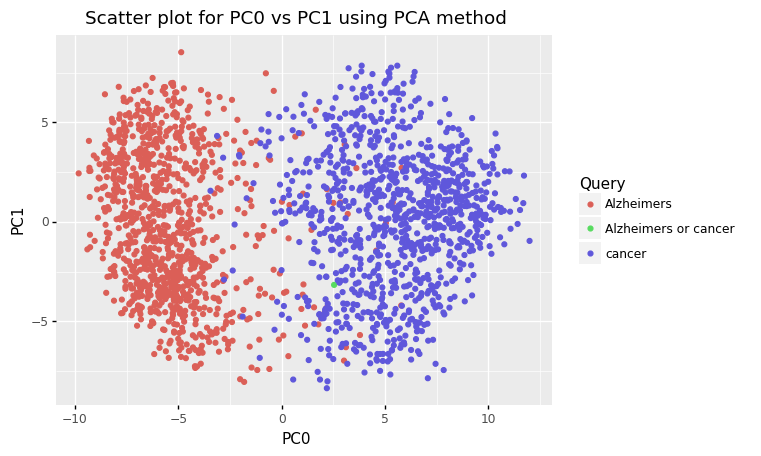

<ggplot: (122759582172)>

In [62]:
# reference: https://datacarpentry.org/python-ecology-lesson/07-visualization-ggplot-python/index.html
# use plotnine to draw the scatterplot between PC0 and PC1. Legends are three queries: Alzheimers, Alzheimers or cancer(outlier), cancer.
(p9.ggplot(data = embeddings_pca, mapping = p9.aes(x='PC0', y='PC1'))
+ p9.geom_point(p9.aes(x = 'PC0', y = 'PC1', color = 'Query'))
+ p9.labs(title = "Scatter plot for PC0 vs PC1 using PCA method"))

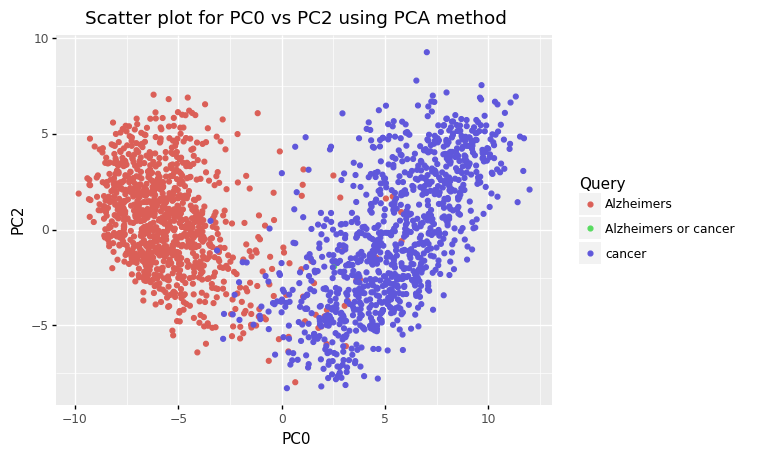

<ggplot: (122756972090)>

In [63]:
# use plotnine to draw the scatterplot between PC0 and PC2. Legends are three queries: Alzheimers, Alzheimers or cancer(outlier), cancer.
(p9.ggplot(data = embeddings_pca, mapping = p9.aes(x='PC0', y='PC2'))
+ p9.geom_point(p9.aes(x = 'PC0', y = 'PC2', color = 'Query'))
+ p9.labs(title = "Scatter plot for PC0 vs PC2 using PCA method"))

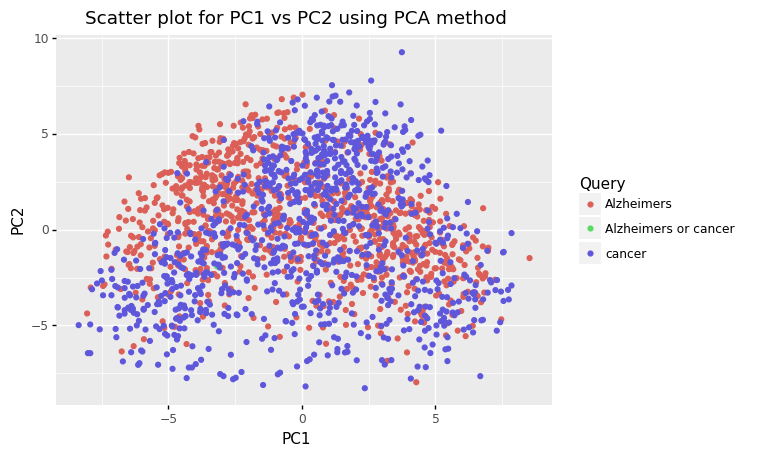

<ggplot: (122759573333)>

In [64]:
# use plotnine to draw the scatterplot between PC1 and PC2. Legends are three queries: Alzheimers, Alzheimers or cancer(outlier), cancer.
(p9.ggplot(data = embeddings_pca, mapping = p9.aes(x='PC1', y='PC2'))
+ p9.geom_point(p9.aes(x = 'PC1', y = 'PC2', color = 'Query'))
+ p9.labs(title = "Scatter plot for PC1 vs PC2 using PCA method"))

In [66]:
# import classifier LinearDiscriminantAnalysis and library numpy.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np

In [24]:
# create a one-dimensional vector y as target values.
y = []
for key in all_data.keys():
    # If query was Alzheimer's, y = 0; if query was Alzheimer's and cancer, y = 1; if query was cancer, y = 2.
    if all_data[key]['Query'] == 'Alzheimers':
        y.append(0)
    elif all_data[key]['Query'] == 'Alzheimers or cancer':
        y.append(1)
    elif all_data[key]['Query'] == 'cancer':
        y.append(2)
y = np.array(y)

array([0, 0, 0, ..., 2, 2, 2])

In [25]:
# linear discriminant analysis was applied to identify the first two principal components PC0 and PC1.
lda = LDA(n_components=2)
embeddings_lda = pd.DataFrame(lda.fit_transform(embeddings_total,y),columns=['PC0','PC1'])
embeddings_lda["Query"] = [paper["Query"] for paper in all_data.values()]

In [26]:
embeddings_lda

,PC0,PC1,Query
0,-4.217578,-0.231192,Alzheimers
1,-4.625505,1.308354,Alzheimers
2,-4.908939,1.565123,Alzheimers
3,-4.158724,0.704638,Alzheimers
4,-2.137133,-0.239546,Alzheimers
...,...,...,...
1994,4.418885,1.223128,cancer
1995,4.096872,-0.894132,cancer
1996,4.063724,0.086905,cancer
1997,4.947440,-0.420562,cancer


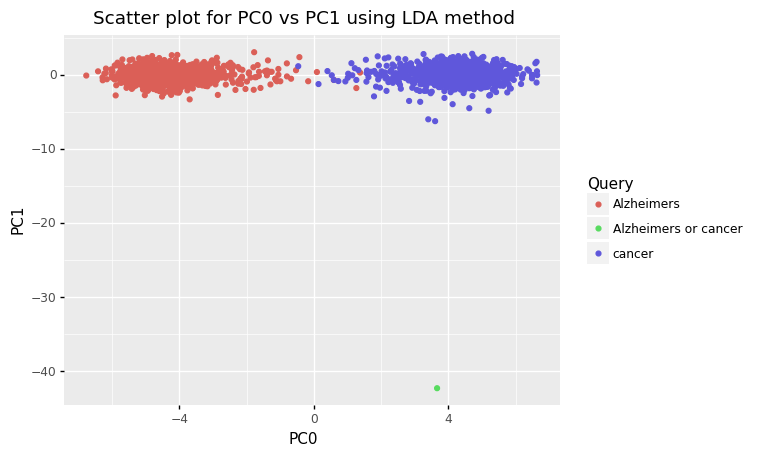

<ggplot: (122756940493)>

In [65]:
# use plotnine to draw the scatterplot between PC0 and PC1. Legends are three queries: Alzheimers, Alzheimers or cancer(outlier), cancer.
(p9.ggplot(data = embeddings_lda, mapping = p9.aes(x='PC0', y='PC1'))
+ p9.geom_point(p9.aes(x = 'PC0', y = 'PC1', color = 'Query'))
+ p9.labs(title = "Scatter plot for PC0 vs PC1 using LDA method"))